In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire_saas import get_saas_data
from prepare_saas import prep_saas_data

In [2]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()

In [3]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

In [4]:
df = get_saas_data()
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [5]:
df = prep_saas_data(df)
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


Using saas.csv or log data from api usage of last week
1. Split data (train/test) and resample by any period except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - simple average
    - moving average
    - Holt's linear trend model
    - Based on previous year/month/etc (your choice)

In [6]:
aggregation = 'sum'

# Sampling

In [7]:
train = df[:'2016'].Amount.resample('M').agg(aggregation)
test = df['2017':].Amount.resample('M').agg(aggregation)

In [8]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 48
Training Observations: 36
Testing Observations: 12


In [9]:
def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

#### 1. Simple Average

In [10]:
yhat = pd.DataFrame(dict(actual=test))

In [11]:
yhat['avg_forecast'] = train.sum()

In [12]:
yhat.head()

,actual,avg_forecast
Month_Invoiced,,
2017-01-31,53395.0,1725000.0
2017-02-28,53440.0,1725000.0
2017-03-31,53480.0,1725000.0
2017-04-30,53350.0,1725000.0
2017-05-31,53340.0,1725000.0


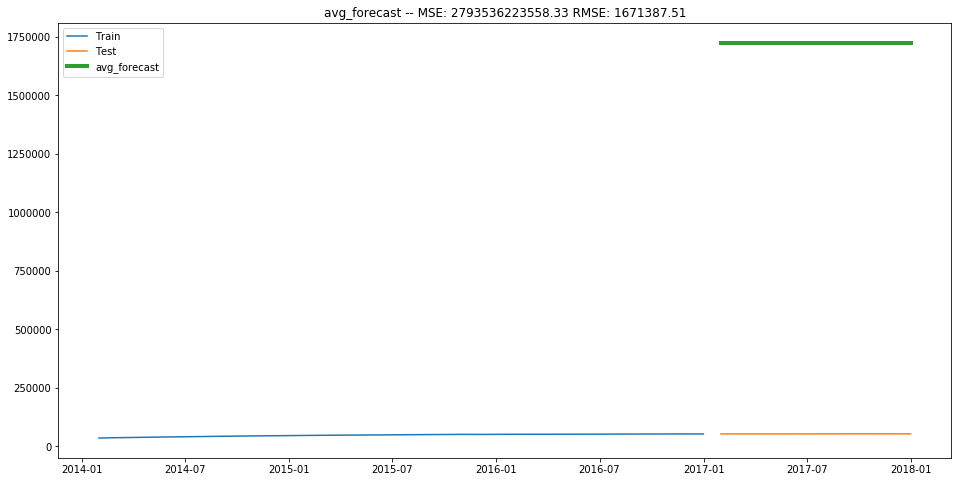

In [13]:
plot_and_eval(yhat.avg_forecast)

#### 2. Moving Average

In [14]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).sum().iloc[-1]

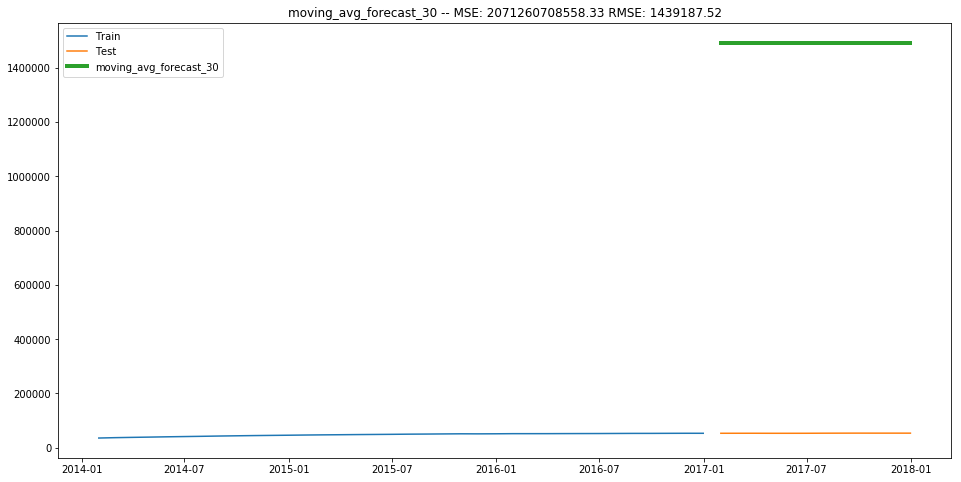

In [15]:
plot_and_eval(yhat.moving_avg_forecast_30)

In [16]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]

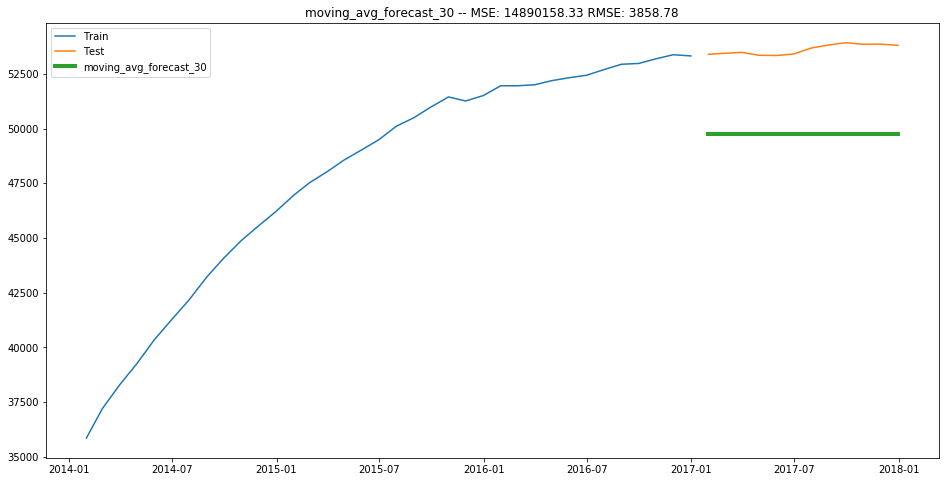

In [17]:
plot_and_eval(yhat.moving_avg_forecast_30)

In [18]:
# period_vals = [1, 4, 12, 26]

# for periods in period_vals:
#     yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).sum().iloc[-1]

# forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

# plot_and_eval(forecasts, linewidth=2)

#### 3. Holts Linear Trend Model

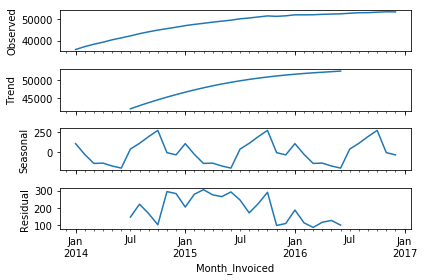

In [19]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

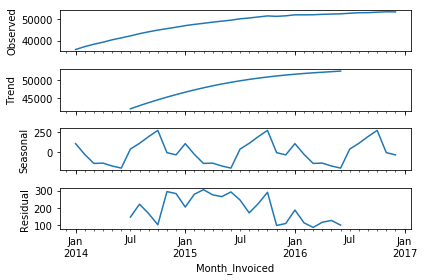

In [20]:
train = df[:'2016'].Amount.resample('M').agg(aggregation)
test = df['2017':].Amount.resample('M').agg(aggregation)

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [21]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.9, smoothing_slope=.6497)

yhat['holt_linear'] = holt.forecast(test.shape[0])

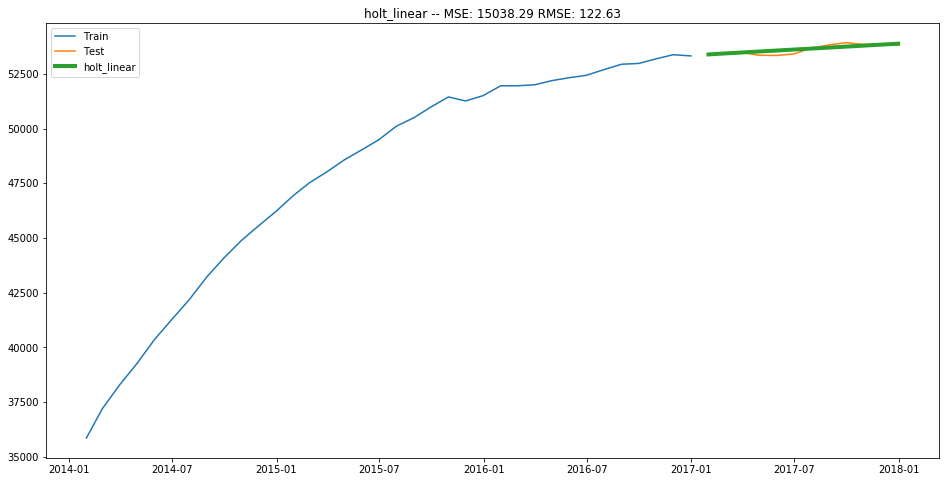

In [22]:
plot_and_eval(yhat.holt_linear)

#### 4. Predicting Based on the Last Year's Data

In [23]:
# note that 2016 was a leap year
using_last_year = train['2016']\
    .reset_index()\
    .drop(columns='Month_Invoiced')\
    .set_index(train['2016'].index + 12)

yhat['last_year'] = using_last_year

In [24]:
yhat

,actual,avg_forecast,moving_avg_forecast_30,holt_linear,last_year
Month_Invoiced,,,,,
2017-01-31,53395.0,1725000.0,49760.0,53387.909676,51955.0
2017-02-28,53440.0,1725000.0,49760.0,53432.503435,51955.0
2017-03-31,53480.0,1725000.0,49760.0,53477.097195,52000.0
2017-04-30,53350.0,1725000.0,49760.0,53521.690954,52190.0
2017-05-31,53340.0,1725000.0,49760.0,53566.284714,52325.0
2017-06-30,53405.0,1725000.0,49760.0,53610.878474,52435.0
2017-07-31,53680.0,1725000.0,49760.0,53655.472233,52695.0
2017-08-31,53820.0,1725000.0,49760.0,53700.065993,52940.0
2017-09-30,53925.0,1725000.0,49760.0,53744.659752,52975.0


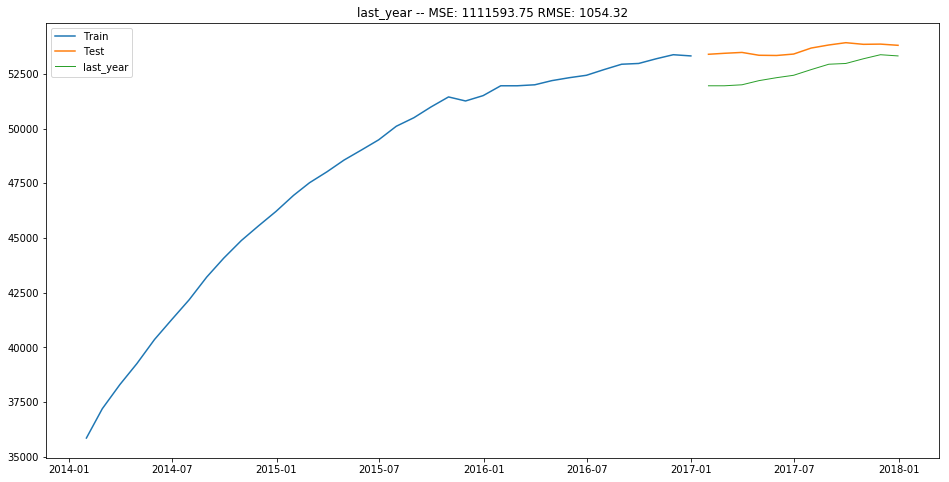

In [25]:
plot_and_eval(yhat.last_year, linewidth=1)

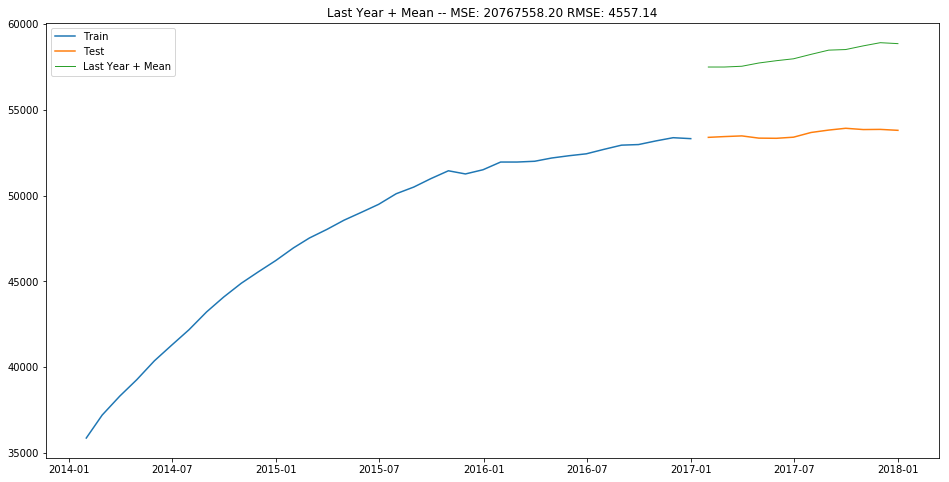

In [26]:
predictions = train['2016'] + train.diff(12).mean()
predictions.index = pd.date_range('20170101', periods=12, freq='M')
predictions.name = 'Last Year + Mean'

plot_and_eval(predictions, linewidth=1)